In [58]:

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

In [38]:
df = pd.read_csv("./dataset/train.csv")
df.size

118260

In [39]:
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


### Les 5 premières variables les plus influentes sur la cible

In [15]:
df_corr = df.corr()
df_corr = df_corr.sort_values('SalePrice', ascending=False)
df_corr['SalePrice'].head()

SalePrice      1.000000
OverallQual    0.790982
GrLivArea      0.708624
GarageCars     0.640409
GarageArea     0.623431
Name: SalePrice, dtype: float64

<i>
OverallQual : Rates the overall material and finish of the house
<br>
GrLivArea : Above grade (ground) living area square feet
</i>

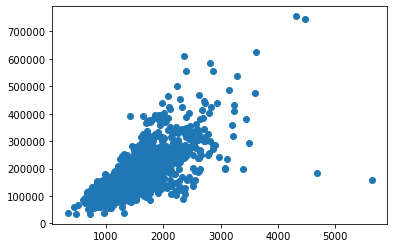

In [33]:
plt.scatter(df.GrLivArea, df.SalePrice);

#### Suppression des outliers extrèmes

In [40]:
df = df.drop(df[(df.GrLivArea > 4000) & (df.SalePrice < 300000)].index)
df.size

118098

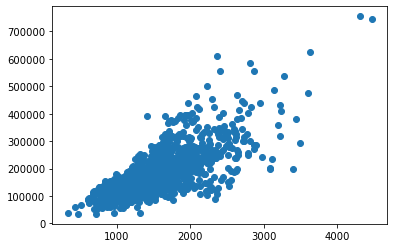

In [41]:
plt.scatter(df.GrLivArea, df.SalePrice);

#### Séparation de la variable explicative et de la cible

In [50]:
# Variables explicatives, une seule
X = df[['GrLivArea']]

# Variable cible
y = df['SalePrice']

In [53]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.15)

### Création des modèles

In [55]:
lr = LinearRegression()

lr.fit(X_train, y_train)

y_pred_train = lr.predict(X_train)

y_pred_test = lr.predict(X_test)

In [57]:
mse_train = mean_squared_error(y_train, y_pred_train)

mse_test = mean_squared_error(y_test, y_pred_test)

print("MSE train lr:", mse_train)
print("MSE test lr:", mse_test)

MSE train lr: 2954005611.381375
MSE test lr: 2621389287.5182056


In [59]:
mae_train = mean_absolute_error(y_train, y_pred_train)

mae_test = mean_absolute_error(y_test, y_pred_test)

print("MAE train lr:", mae_train)
print("MAE test lr:", mae_test)

mean_price = df['SalePrice'].mean()

print("\nRelative error", mae_test / mean_price)

MAE train lr: 37459.24545147221
MAE test lr: 38192.196681636975

Relative error 0.21108484226382726


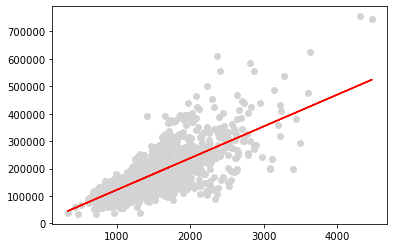

In [66]:
plt.scatter(X, y,color='lightgrey');
plt.plot(X, lr.predict(X),color='r');